In [15]:
using Revise
using Plots, StatsPlots
default(titlefontsize = 10)

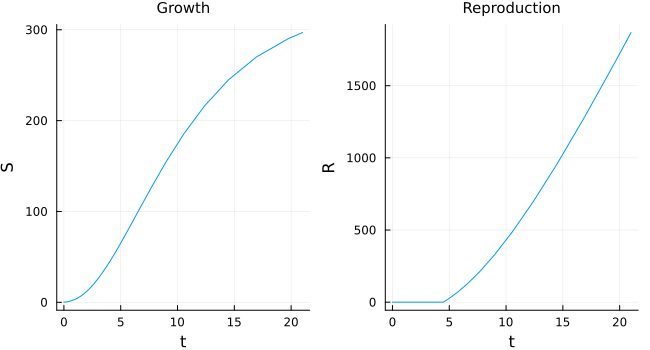

In [19]:
using DEBBase
out = simulator(BaseParamCollection())

@df out plot(
    plot(:t, :S, ylabel = "S"), 
    plot(:t, :R, ylabel = "R");
    leg = false, 
    title = ["Growth" "Reproduction"], xlabel = "t", 
    size = (650,350)
)

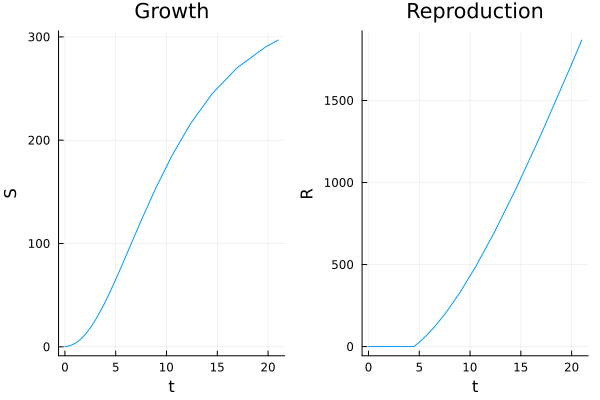